In [1]:
from __future__ import print_function

import copy
from IPython.display import Audio, display
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
from configs import configs
from losses import CustomLoss
from models import SoundStyleTransfer
from run_functions import run_style_transfer
from utils import GetSpectrogram

In [3]:
##### Run with GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/dabsdamoon/anaconda3/envs/audio_style_transfer_test/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554788289/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
##### Load style and content
CONTENT_FILENAME = "./inputs/imperial.mp3"
STYLE_FILENAME = "./style/usa.mp3"

In [9]:
display(Audio(CONTENT_FILENAME, rate=configs.sampling_rate))
display(Audio(STYLE_FILENAME, rate=configs.sampling_rate))

In [11]:
##### Reads wav file and produces spectrum

'''
With stft, the height becomes frequency (Hz).
Frequency means the value that FFT is applied with given sample rate.
'''
N_FFT = configs.N_FFT

get_spectrogram = GetSpectrogram(configs)

m_content, p_content = get_spectrogram(CONTENT_FILENAME)
m_style, p_style = get_spectrogram(STYLE_FILENAME)

N_SAMPLES = m_content.shape[2]
N_CHANNELS = m_content.shape[1]
m_style = m_style[:N_CHANNELS, :N_SAMPLES]

/home/dabsdamoon/anaconda3/envs/audio_style_transfer_test/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/dabsdamoon/anaconda3/envs/audio_style_transfer_test/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [12]:
# Add N_SAMPLES and N_CHANNELS to configs
print(N_SAMPLES, N_CHANNELS)
configs.N_SAMPLES = N_SAMPLES
configs.N_CHANNELS = N_CHANNELS

862 513


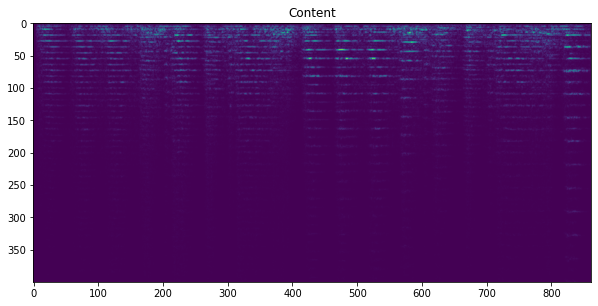

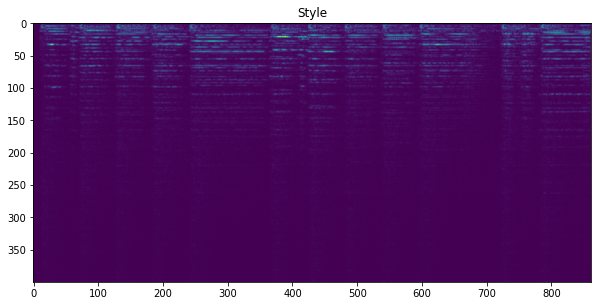

In [13]:
##### View content and style spectrogram

plt.figure(figsize=(10, 5))
plt.title('Content')
plt.imshow(m_content[0,:400,:].detach().cpu().numpy())
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Style')
plt.imshow(m_style[0,:400,:].detach().cpu().numpy())
plt.show()

In [14]:
### Compute content and style feats

N_FILTERS = configs.N_FILTERS

m_content_tf = torch.unsqueeze(m_content[0].t(), 0)
m_content_tf = torch.unsqueeze(m_content_tf, 0)

m_style_tf = torch.unsqueeze(m_style[0].t(), 0)
m_style_tf = torch.unsqueeze(m_style_tf, 0)

m_content_tensor = torch.tensor(m_content_tf, dtype=torch.float32).permute(0,3,1,2)
m_style_tensor = torch.tensor(m_style_tf, dtype=torch.float32).permute(0,3,1,2)

<ipython-input-14-a0a4b81dd5be>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_content_tensor = torch.tensor(m_content_tf, dtype=torch.float32).permute(0,3,1,2)
<ipython-input-14-a0a4b81dd5be>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_style_tensor = torch.tensor(m_style_tf, dtype=torch.float32).permute(0,3,1,2)


In [15]:
# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std

In [18]:
##### Run style transfer

model_init = SoundStyleTransfer(N_CHANNELS,N_FILTERS)

input_tensor = torch.tensor(np.random.randn(1,N_CHANNELS, 1,N_SAMPLES).astype(np.float32)*1e-3, 
                            dtype=torch.float32,
                            requires_grad=True)

output = run_style_transfer(model_init,
                            m_content_tensor, m_style_tensor, input_tensor,
                            configs)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 513.861450 Content Loss: 3035.173340

run [100]:
Style Loss : 388.289886 Content Loss: 2871.626709

run [150]:
Style Loss : 380.545258 Content Loss: 2857.963135

run [200]:
Style Loss : 378.537415 Content Loss: 2855.425537

run [250]:
Style Loss : 377.869141 Content Loss: 2854.598633

run [300]:
Style Loss : 377.645294 Content Loss: 2854.085205



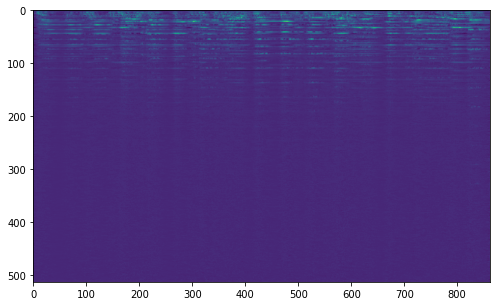

In [19]:
##### Get and view results

result = output.permute(0,2,3,1)[0,:,:]

for_view = result[0].detach().cpu().numpy().T
plt.figure(figsize=(10, 5))
plt.imshow(for_view)
plt.show()

In [21]:
##### Reconstruct with content phase

audio_reconstruct = get_spectrogram.stft.inverse(result.permute(0,2,1), p_content)
Audio(audio_reconstruct[0][0].detach().cpu().numpy(), rate = configs.sampling_rate)